The system is governed by

\begin{equation}
\nabla\cdot \vec{u}_{tot} = 0,
\end{equation}

\begin{equation}
\partial_t \vec{u}_{tot}+\vec{u}\cdot\nabla\vec{u}_{tot} = -\nabla p_{tot} + \frac{Pr}{Pe}\nabla^2\vec{u}_{tot} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\vec{e}_z,
\end{equation}

\begin{equation}
\partial_t T +\vec{u}_{tot}\cdot\nabla T - w_{tot} = \frac{1}{Pe}\nabla^2 T,
\end{equation}

\begin{equation}
\partial_t S +\vec{u}_{tot}\cdot\nabla S - R_\rho w_{tot} = \frac{\tau}{Pe}\nabla^2 S.
\end{equation}

Decomposing nonlinear terms
$$
\vec{u}_{tot} = \bar{u}\vec{e}_x + \vec{u},
$$
$$
\vec{u}_{tot}\cdot\nabla T = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla T = \bar{u}\partial_x T + \vec{u}\cdot\nabla T,
$$
$$
\vec{u}_{tot}\cdot\nabla S = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla S = \bar{u}\partial_x S + \vec{u}\cdot\nabla S,
$$
$$
\vec{u}_{tot}\cdot\nabla \vec{u}_{tot} = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla (\bar{u}\vec{e}_x + \vec{u})\\
= \bar{u}\vec{e}_x\cdot\nabla\bar{u}\vec{e}_x + \bar{u}\vec{e}_x\cdot\nabla\vec{u} + \vec{u}\cdot\nabla\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u}\\
= 0 + \bar{u}\partial_x\vec{u} + w\partial_z\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u},
$$

The gevorning equations become:
\begin{equation}
\nabla\cdot \vec{u}_{tot} = \nabla\cdot (\bar{u}\vec{e}_x + \vec{u}) = \nabla\cdot \vec{u} = 0,
\end{equation}

\begin{equation}
\partial_t \vec{u}+\bar{u}\partial_x\vec{u} + w\partial_z\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u} = -\nabla p + \frac{Pr}{Pe}\nabla^2\vec{u} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\vec{e}_z,
\end{equation}

\begin{equation}
\partial_t T +\bar{u}\partial_x T + \vec{u}\cdot\nabla T - w = \frac{1}{Pe}\nabla^2 T,
\end{equation}

\begin{equation}
\partial_t S +\bar{u}\partial_x S + \vec{u}\cdot\nabla S - R_\rho w = \frac{\tau}{Pe}\nabla^2 S.
\end{equation}

[[0.         0.00537634 0.01075269 0.01612903 0.02150538 0.02688172
  0.03225806 0.03763441 0.04301075 0.0483871  0.05376344 0.05913978
  0.06451613 0.06989247 0.07526882 0.08064516 0.08602151 0.09139785
  0.09677419 0.10215054 0.10752688 0.11290323 0.11827957 0.12365591
  0.12903226 0.1344086  0.13978495 0.14516129 0.15053763 0.15591398
  0.16129032 0.16666667 0.17204301 0.17741935 0.1827957  0.18817204
  0.19354839 0.19892473 0.20430108 0.20967742 0.21505376 0.22043011
  0.22580645 0.2311828  0.23655914 0.24193548 0.24731183 0.25268817
  0.25806452 0.26344086 0.2688172  0.27419355 0.27956989 0.28494624
  0.29032258 0.29569892 0.30107527 0.30645161 0.31182796 0.3172043
  0.32258065 0.32795699 0.33333333 0.33870968 0.34408602 0.34946237
  0.35483871 0.36021505 0.3655914  0.37096774 0.37634409 0.38172043
  0.38709677 0.39247312 0.39784946 0.40322581 0.40860215 0.41397849
  0.41935484 0.42473118 0.43010753 0.43548387 0.44086022 0.44623656
  0.4516129  0.45698925 0.46236559 0.46774194 0.4

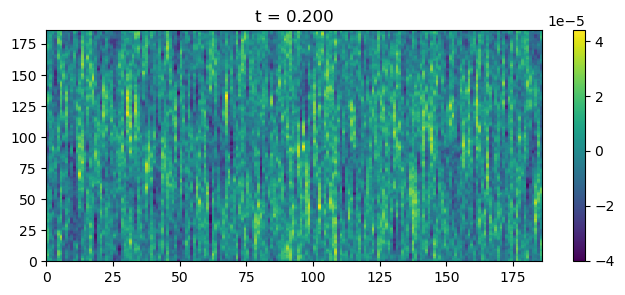

Completed iteration 101, time=20.200, dt=0.200


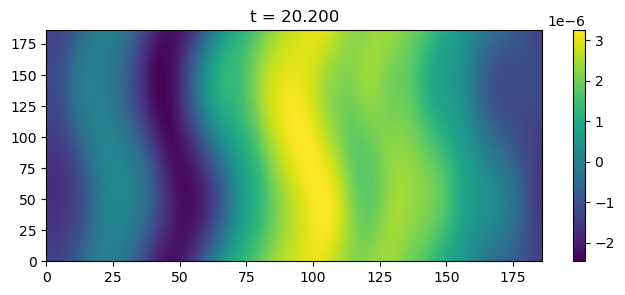

Completed iteration 201, time=40.200, dt=0.200


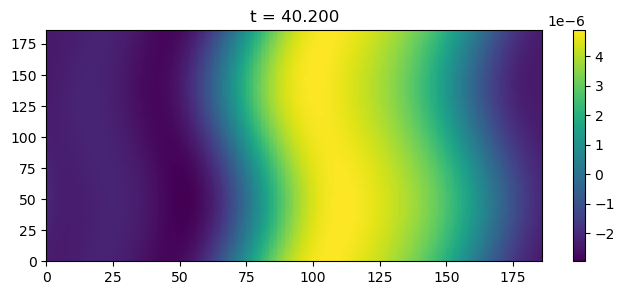

Completed iteration 301, time=60.200, dt=0.200


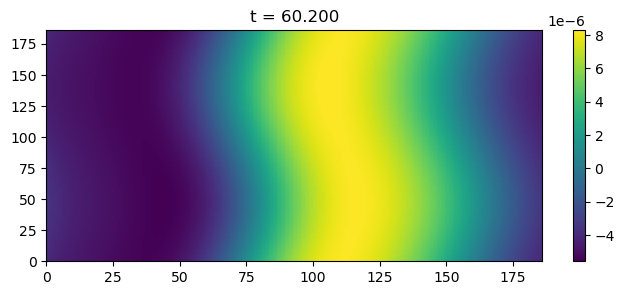

Completed iteration 401, time=80.200, dt=0.200


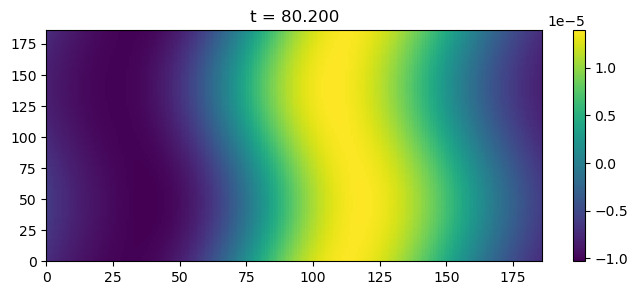

Completed iteration 501, time=100.200, dt=0.200


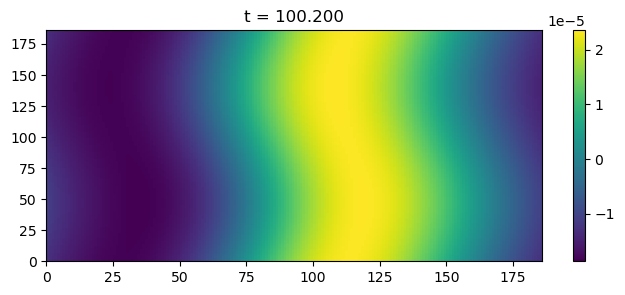

Completed iteration 601, time=120.200, dt=0.200


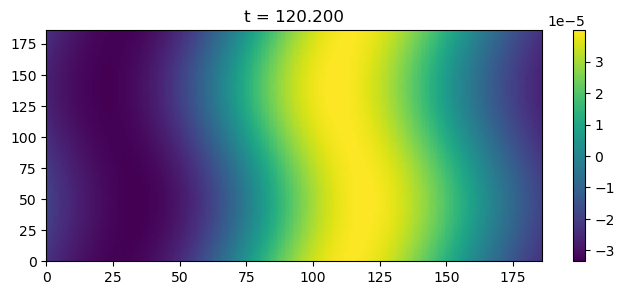

Completed iteration 701, time=140.200, dt=0.200


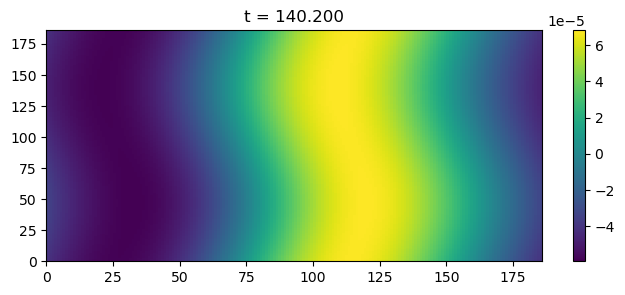

Completed iteration 801, time=160.200, dt=0.200


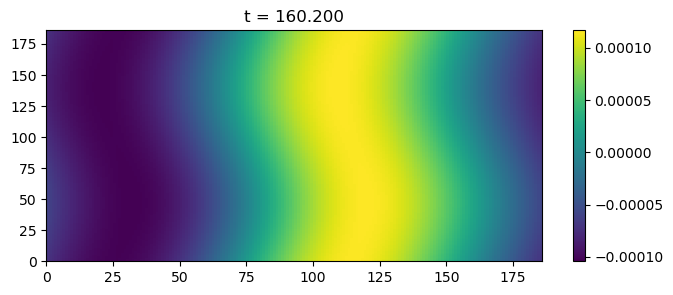

Completed iteration 901, time=180.200, dt=0.200


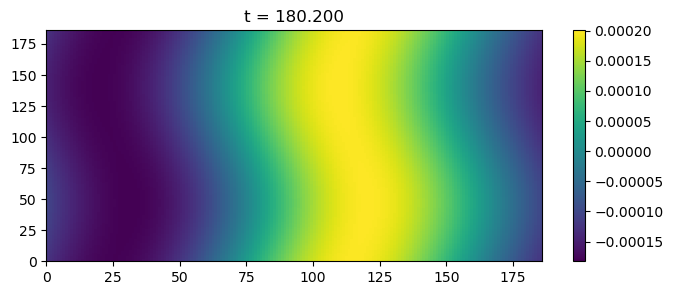

Completed iteration 1001, time=200.200, dt=0.200


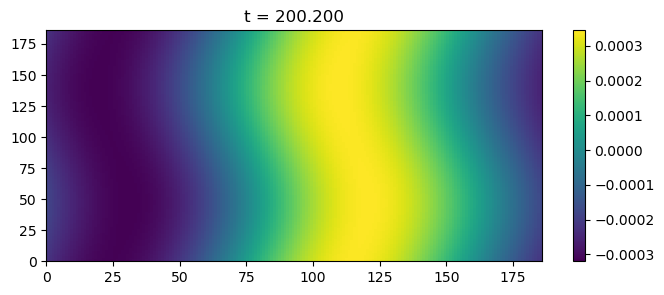

Completed iteration 1101, time=220.200, dt=0.200


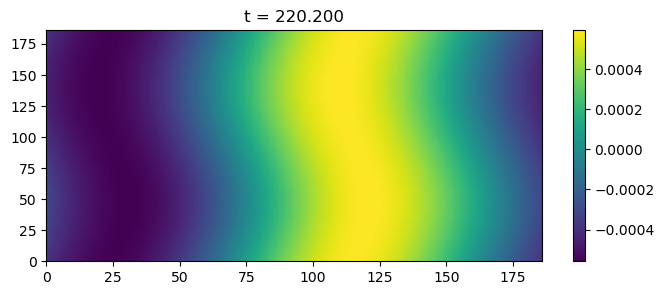

Completed iteration 1201, time=240.200, dt=0.200


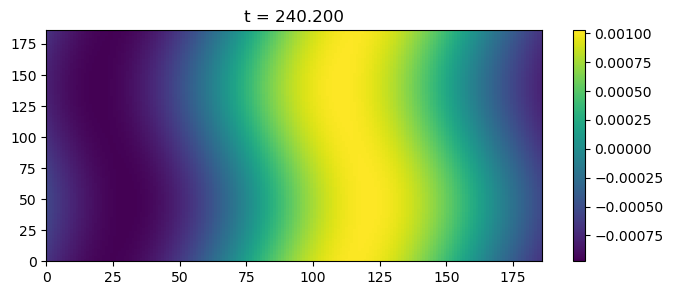

Completed iteration 1301, time=260.200, dt=0.200


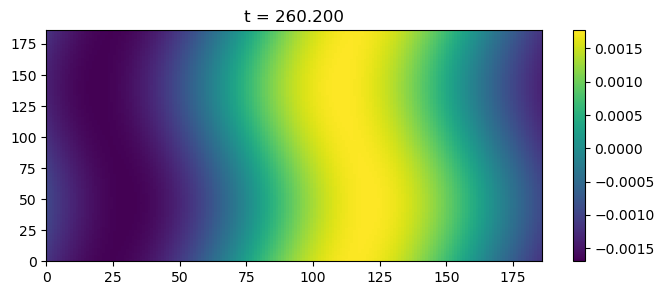

Completed iteration 1401, time=280.200, dt=0.200


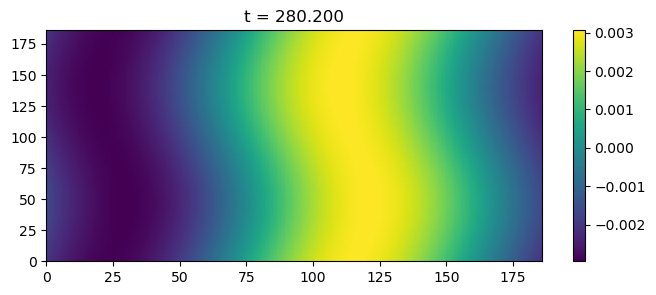

Completed iteration 1501, time=300.200, dt=0.200


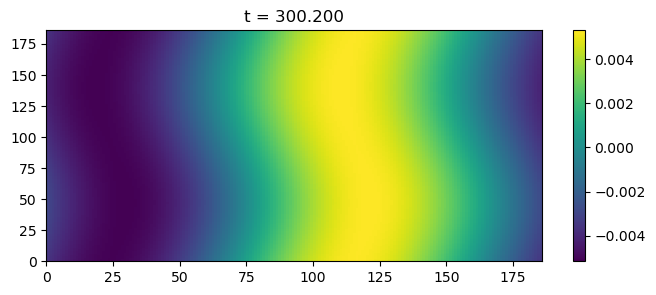

Completed iteration 1601, time=320.200, dt=0.200


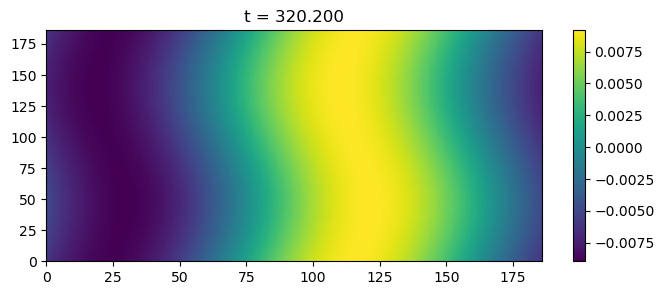

Completed iteration 1701, time=340.200, dt=0.200


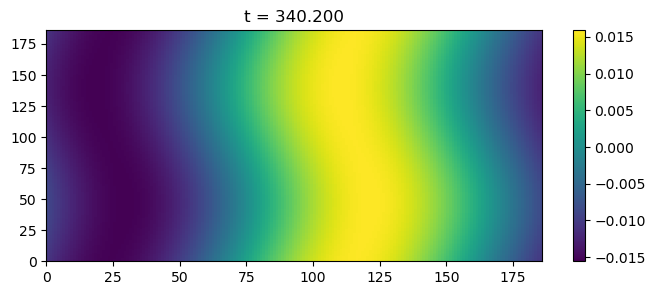

Completed iteration 1801, time=360.200, dt=0.200


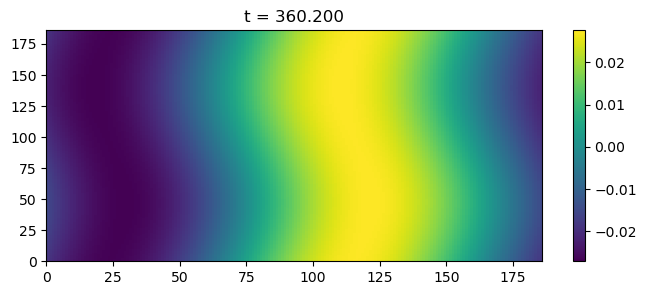

Completed iteration 1901, time=380.200, dt=0.200


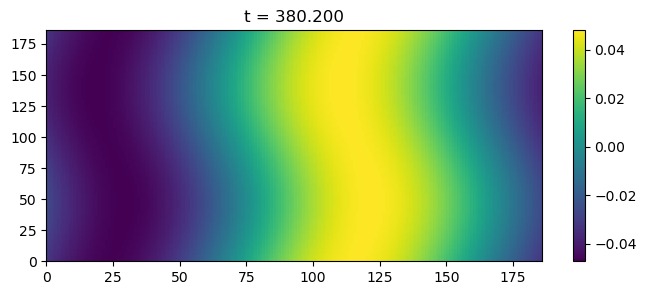

In [2]:
# This code performs two-dimensional DNS using Dedalus3 based on governing equations in Radko's paper 
# [Thermohaline layering in dynamically and diffusively stable shear flows]
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

dealias = 1           # scaling factor
pi = np.pi

# reproduce the results in figure 4
# Rp, Ri, Pe, tau = 2., 1., 1e4, 0.01 # figure 3
Rp, Ri, Pe, tau = 2., 10., 1e2, 0.01 # figure 4

Pr = 10.  # Prandtl number

Lx, Lz = 64., 1.
Nx, Nz = 186, 186
# Nx, Nz = 384, 192
# Nx, Nz = 768, 384

# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=np.float64)
# define the coordinate system
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)
# define fields
p = dist.Field(name='p', bases=(xbasis,zbasis)) # pressure
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis)) # velocity
sa = dist.Field(name='sa', bases=(xbasis,zbasis)) # salinity
te = dist.Field(name='te', bases=(xbasis,zbasis)) # temperature
baru = dist.Field(bases=(zbasis))
# Substitutions
x, z = dist.local_grids(xbasis, zbasis) # get coordinate arrays in horizontal and vertical directions
ex, ez = coords.unit_vector_fields(dist) # get unit vectors in horizontal and vertical directions
# define vertical velocity component
w = u @ ez


# create constant sub-field for incompressible flow condition's equation
tau_p = dist.Field(name='tau_p') 
# because this term is only a contant added to the equation, we don't need to instantiate it for bases system

grad_te = d3.grad(te) # First-order reduction
grad_sa = d3.grad(sa) # First-order reduction
grad_u = d3.grad(u) # First-order reduction
# First-order form: "lap(f)" becomes "div(grad_f)"
lap_u = d3.div(grad_u)
lap_te = d3.div(grad_te)
lap_sa = d3.div(grad_sa)
# First-order form: "div(A)" becomes "trace(grad_A)"

dx = lambda A: d3.Differentiate(A, coords['x']) 
dz = lambda A: d3.Differentiate(A, coords['z']) 


baru['g'] = np.sin(2.*pi*z)
print(z)
print(baru['g'])

# baru = np.sin(2*pi*z)

# Problem
problem = d3.IVP([p, tau_p, u, te, sa], namespace=locals())

# add equations
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge
problem.add_equation("dt(u) + baru*dx(u) + w*dz(baru)*ex + grad(p) - (Pr/Pe)*lap_u - (4*pi*pi*Ri/(Rp-1))*(te-sa)*ez = - u@grad(u)")
problem.add_equation("dt(te) + baru*dx(te) - (1./Pe)*lap_te - w = - u@grad(te)")
problem.add_equation("dt(sa) + baru*dx(sa) - (tau/Pe)*lap_sa - Rp*w = - u@grad(sa)")

stop_sim_time = 1000 # Stopping criteria
# timestepper = d3.RK443 # 3rd-order 4-stage DIRK+ERK scheme [Ascher 1997 sec 2.8] https://doi-org.ezproxy.lib.uconn.edu/10.1016/S0168-9274(97)00056-1
timestepper = d3.RK222

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# define initial condition

p.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
u.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
te.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
sa.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise

max_timestep = 0.2
# CFL
# CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
#              max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=1,safety=0.5,max_dt=max_timestep,min_dt=0.000000001,
            #  threshold=0.05,
            max_change=1.5, min_change=0.5
             )
CFL.add_velocity(u)

# Main loop
print('Starting main loop')
while solver.proceed:
    timestep = CFL.compute_timestep()
    solver.step(timestep)
    if solver.sim_time>400:
        print('dt={:.3f})'.format(timestep))
    if (solver.iteration-1) % 100 == 0:
        print('Completed iteration {}, time={:.3f}, dt={:.3f}'.format(solver.iteration, solver.sim_time, timestep))
        temp = np.copy(te['g'])
        plt.figure(figsize=(8,3))
        te_plot = plt.pcolormesh(temp.transpose())
        plt.colorbar(te_plot) 
        plt.title("t = {:.3f}".format(solver.sim_time))
        plt.show()